# Toxic comments

This notebook takes you though a complete iteration of Machine Learning Assignment 1 - Toxic comments. The assignment details (including links to download the data) can be found [here](https://docs.google.com/document/d/1WGYw99e5q6j5V0Zrf2HveagU6URt_kVvdR8B9HYQ99E/edit?usp=sharing). 

In [1]:
# all imports and magic commands
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from my_measures import BinaryClassificationPerformance
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using `BinaryClassificationPerformance` v1.02

In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.02
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

# Function for feature building and extraction on natural language data

In [24]:
# function that takes raw data and completes all preprocessing required before model fits
def process_raw_data(fn, my_random_seed, test=False):
    # read and summarize data
    toxic_data = pd.read_csv(fn)
    if (not test):
        # add an indicator for any toxic, severe toxic, obscene, threat, insult, or indentity hate
        toxic_data['any_toxic'] = (toxic_data['toxic'] + toxic_data['severe_toxic'] + toxic_data['obscene'] + toxic_data['threat'] + toxic_data['insult'] + toxic_data['identity_hate'] > 0)
    print("toxic_data is:", type(toxic_data))
    print("toxic_data has", toxic_data.shape[0], "rows and", toxic_data.shape[1], "columns", "\n")
    print("the data types for each of the columns in toxic_data:")
    print(toxic_data.dtypes, "\n")
    print("the first 10 rows in toxic_data:")
    print(toxic_data.head(5))
    if (not test):
        print("The rate of 'toxic' Wikipedia comments in the dataset: ")
        print(toxic_data['any_toxic'].mean())
    
    if (not test): # fit_transform()
        count_vectorizer = CountVectorizer(max_features=10000)
        X_cv = count_vectorizer.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(count_vectorizer)
        print("Shape of HashingVectorizer X:")
        print(X_cv.shape)
    else: # transform() 
        X_cv = fitted_transformations[0].transform(toxic_data.comment_text)
        print("Shape of HashingVectorizer X:")
        print(X_cv.shape)
    
    if (not test):
        count_vectorizer2 = CountVectorizer(analyzer='word', ngram_range=(3, 5), max_features=200000)
        X_cv2 = count_vectorizer2.fit_transform(toxic_data.comment_text)
        fitted_transformations.append(count_vectorizer2)
    else:
        X_cv2 = fitted_transformations[1].transform(toxic_data.comment_text)
        
    if (not test):
        transformer = TfidfTransformer(smooth_idf=False)
        X_tfidf = transformer.fit_transform(X_cv)
        fitted_transformations.append(transformer)
    else:
        X_tfidf = fitted_transformations[2].transform(X_cv)
        
    
    # create regex for uppercase words 
    uppercase_pattern = '([A-Z]){2,}'
    
    # create additional quantitative features
    # features from Amazon.csv to add to feature set
    toxic_data['exclam_count'] = toxic_data['comment_text'].str.count("\!")
    toxic_data['uppercase'] = len(re.findall(uppercase_pattern, str(toxic_data['comment_text'])))   
    toxic_data['questions'] = len(re.findall('(\?){3,}', str(toxic_data['comment_text'])))

    X_quant_features = toxic_data[["exclam_count", "uppercase", "questions"]]
    print("Look at a few rows of the new quantitative features: ")
    print(X_quant_features.head(100))
    
    # Combine all quantitative features into a single sparse matrix
    X_quant_features_csr = csr_matrix(X_quant_features)
    X_combined = hstack([X_tfidf, X_cv2, X_quant_features_csr])
    X_matrix = csr_matrix(X_combined) # convert to sparse matrix
    print("Size of combined bag of words and new quantitative variables matrix:")
    print(X_matrix.shape)
    
    # Create `X`, scaled matrix of features
    # feature scaling
    if (not test):
        sc = StandardScaler(with_mean=False)
        X = sc.fit_transform(X_matrix)
        fitted_transformations.append(sc)
        print(X.shape)
        y = toxic_data['any_toxic']
    else:
        X = fitted_transformations[3].transform(X_matrix)
        print(X.shape)
    
    # Create Training and Test Sets
    # enter an integer for the random_state parameter; any integer will work
    if (test):
        X_submission_test = X
        print("Shape of X_test for submission:")
        print(X_submission_test.shape)
        print('SUCCESS!')
        return(toxic_data, X_submission_test)
    else: 
        X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = train_test_split(X, y, toxic_data, test_size=0.2, random_state=my_random_seed)
        print("Shape of X_train and X_test:")
        print(X_train.shape)
        print(X_test.shape)
        print("Shape of y_train and y_test:")
        print(y_train.shape)
        print(y_test.shape)
        print("Shape of X_raw_train and X_raw_test:")
        print(X_raw_train.shape)
        print(X_raw_test.shape)
        print('SUCCESS!')
        return(X_train, X_test, y_train, y_test, X_raw_train, X_raw_test)

# Create training and test sets from function

In [25]:
# create an empty list to store any use of fit_transform() to transform() later
# it is a global list to store model and feature extraction fits
fitted_transformations = []

# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
X_train, X_test, y_train, y_test, X_raw_train, X_raw_test = process_raw_data(fn='data/toxiccomments_train.csv', my_random_seed=97)

print("Number of fits stored in `fitted_transformations` list: ")
print(len(fitted_transformations))

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 159571 rows and 9 columns 

the data types for each of the columns in toxic_data:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
any_toxic          bool
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  any_toxic  
0             0        0     

# Fit (and tune) Various Models

### MODEL: ordinary least squares

In [26]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X_train, y_train)

ols_performance_train = BinaryClassificationPerformance(ols.predict(X_train), y_train, 'ols_train')
ols_performance_train.compute_measures()
print(ols_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 6494, 'TN': 57090, 'FP': 57556, 'FN': 6516, 'Accuracy': 0.4980886131478348, 'Precision': 0.10138953942232631, 'Recall': 0.4991544965411222, 'desc': 'ols_train'}


### MODEL: SVM, linear

In [27]:
from sklearn import linear_model
svm = linear_model.SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=1, max_iter=5, tol=None)
svm.fit(X_train, y_train)

svm_performance_train = BinaryClassificationPerformance(svm.predict(X_train), y_train, 'svm_train')
svm_performance_train.compute_measures()
print(svm_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12578, 'TN': 114224, 'FP': 422, 'FN': 432, 'Accuracy': 0.9933101460174218, 'Precision': 0.9675384615384616, 'Recall': 0.9667947732513451, 'desc': 'svm_train'}


### MODEL: logistic regression

In [28]:
from sklearn import linear_model
lgs = linear_model.SGDClassifier(loss='log')
lgs.fit(X_train, y_train)

lgs_performance_train = BinaryClassificationPerformance(lgs.predict(X_train), y_train, 'lgs_train')
lgs_performance_train.compute_measures()
print(lgs_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12889, 'TN': 114528, 'FP': 118, 'FN': 121, 'Accuracy': 0.9981277809111988, 'Precision': 0.9909279618666872, 'Recall': 0.9906994619523444, 'desc': 'lgs_train'}


### MODEL: Naive Bayes

In [29]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB(alpha=1e-3, fit_prior=True)
nbs.fit(X_train, y_train)

nbs_performance_train = BinaryClassificationPerformance(nbs.predict(X_train), y_train, 'nbs_train')
nbs_performance_train.compute_measures()
print(nbs_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12957, 'TN': 103419, 'FP': 11227, 'FN': 53, 'Accuracy': 0.9116375258507238, 'Precision': 0.5357674495534237, 'Recall': 0.9959262106072252, 'desc': 'nbs_train'}


### MODEL: Perceptron

In [30]:
from sklearn import linear_model
prc = linear_model.SGDClassifier(loss='perceptron', max_iter=10000, alpha=0.00001, tol=1)
prc.fit(X_train, y_train)

prc_performance_train = BinaryClassificationPerformance(prc.predict(X_train), y_train, 'prc_train')
prc_performance_train.compute_measures()
print(prc_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12849, 'TN': 114470, 'FP': 176, 'FN': 161, 'Accuracy': 0.9973600927492636, 'Precision': 0.9864875239923224, 'Recall': 0.9876249039200615, 'desc': 'prc_train'}


### MODEL: Ridge Regression Classifier

In [31]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(normalize=True, alpha=3, tol=0.0001, solver='sag', random_state=0)
rdg.fit(X_train, y_train)

rdg_performance_train = BinaryClassificationPerformance(rdg.predict(X_train), y_train, 'rdg_train')
rdg_performance_train.compute_measures()
print(rdg_performance_train.performance_measures)

{'Pos': 13010, 'Neg': 114646, 'TP': 12930, 'TN': 102781, 'FP': 11865, 'FN': 80, 'Accuracy': 0.9064282133233064, 'Precision': 0.5214761040532365, 'Recall': 0.9938508839354343, 'desc': 'rdg_train'}


### MODEL: Random Forest Classifier

In [11]:
from sklearn.ensemble import RandomForestClassifier
rdf = RandomForestClassifier(max_depth=100, random_state=1)
rdf.fit(X_train, y_train)

rdf_performance_train = BinaryClassificationPerformance(rdf.predict(X_train), y_train, 'rdf_train')
rdf_performance_train.compute_measures()
print(rdf_performance_train.performance_measures)

/Users/marisaasari/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


{'Pos': 13010, 'Neg': 114646, 'TP': 4658, 'TN': 114644, 'FP': 2, 'FN': 8352, 'Accuracy': 0.9345585009713605, 'Precision': 0.9995708154506437, 'Recall': 0.35803228285933897, 'desc': 'rdf_train'}


### ROC plot to compare performance of various models and fits

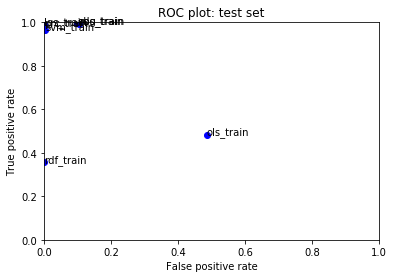

In [12]:
fits = [ols_performance_train, svm_performance_train, lgs_performance_train, nbs_performance_train, prc_performance_train, rdg_performance_train, rdf_performance_train]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

### looking at reviews based on their classification

Let's say we decide that Ordinary Least Squares (OLS) Regression is the best model for generalization. Let's take a look at some of the reviews and try to make a (subjective) determination of whether it's generalizing well. 

In [32]:
rdg_predictions = rdg.predict(X_train)

### let's look at some false positives:

In [33]:
# false positives

print("Examples of false positives:")

import random, time

for i in range(0, len(rdg_predictions)):
    if (rdg_predictions[i] == 1):
        if (X_raw_train.iloc[i]['any_toxic'] == 0):
            if (random.uniform(0, 1) < 0.05): # to print only 5% of the false positives
                print(i)
                print(X_raw_train.iloc[i]['comment_text'])
                print('* * * * * * * * * ')


Examples of false positives:
142
Hmm... vandalist brings up what I thought to be a tired point. But I got to tell you. That such an inane article can be so lengthy makes me wonder what the hell I am contributing to.
* * * * * * * * * 
213
== SPECIAL NOTICE ==
Apparently everyone here hates me for trying to be helpful, so I'm going to take a break from WikiPedia.
(Thinks to self: Jeez, every little thing sets these people off.) I'll be back Monday, February 16th, 2009. -
* * * * * * * * * 
437
Janis Joplin

I had to go back and see who was responsible for the terrible bit of misinformation in Janis Joplin.  I assumed it was someone young and unfamiliar with the history of rock 'n' roll.  1958, huh?  Nope.  You're definitely old enough to know better.  Shame on you!  (No response expected  but if you haven't already, go back and read the changes to your verbiage about Joplin being an innovator, 'cause you definitely need educating.) Your erroneous text is precisely the kind of thing blac

6476
LOL. Just another example of how great Wikipedia really is.
* * * * * * * * * 
6523
Help!!! Me begging you.
* * * * * * * * * 
6737
"==Please Remove Block Placed by Drmies==

"
* * * * * * * * * 
6945
"
She's back in rehab again? Damn gorl, giving Winehouse a run for money? —  (talk2me) "
* * * * * * * * * 
7259
Ah, gee, I thought Alistair Haines might deny the charges or something.   You mean I might not be able to come here any more and listen to some dodohead shoot everybody down and destroy the wiki promise?  Oh, I just don't know if I can survive the grief!
* * * * * * * * * 
7601
Ooh, I bet that must make Mitchell feel real lousy. Having the reliability of his book questioned by Wikipedia, the paragon of credibility!
* * * * * * * * * 
7725
": Reference is made to Bloom's homosexuality and AIDS on page 226 of the book ""Unacknowledged Legislation"" by Christopher Hitchens.  His homosexuality is mentioned on page 195 of ""Bound and Gagged"" by Laura Kipnis.  His homosexuality

17019
Cross Platform Harassment 

Ok, so you made me find my login and come over here. Time to dust off my editing tools. -)
* * * * * * * * * 
17118
Well Hey There How are you
* * * * * * * * * 
17302
Silver seren cares not about BLP 

Jimbo, we here in the City of the Big Shoulders wonder what you would say to
* * * * * * * * * 
17333
Schools Out
I dont know who would be reading this, but, SCHOOLS OUT FOR THE SUMMER!!!  HELL YA!!!
* * * * * * * * * 
17350
Hey Pal 

A bit of poetry for you:

  well
  i totaled my car
  cop gave me a break
  i was obviously drinign
 
  everythign got stolen out of my car
  i wasnt hammered
  i was tired
  i felle asleep
  THEY STOLE MY UMBRELLA
* * * * * * * * * 
17441
Not at this time, fag.
* * * * * * * * * 
17544
I knew I was right & you know it too.
* * * * * * * * * 
18155
NAMBLA

You think people like corax, and clayboy don't have any aim in posting in the NAMBLA and pedophile pages?
* * * * * * * * * 
18219
You have a lot of nerve accusing me of

27259
seriously, you used to be better at this
* * * * * * * * * 
27390
Who are you? 

And what do you have to do with anything?!

Like I care what you have to say?
* * * * * * * * * 
27404
"
""shallow""!?! Are you fooling me?   "
* * * * * * * * * 
27629
"
What the heck did I do to deserve this? Im blocked for crying out loud!Coldplay Expért Let's talk "
* * * * * * * * * 
27983
This block is uncalled for and unjustified as he first attacked me.
* * * * * * * * * 
28111
The arch in her back comfirms that she is facing away from us, also she must have like the most deformed nose on the face of the planet to be facing towards us.211.28.54.73
* * * * * * * * * 
28194
From the third party PoV - they'd be peeved that it's just the Democrats & Republican tickets shown. As for who's on the left/right? With Obama on the left, McCain crowds would cry foul & if McCain was on the left, Obama crowds would cry foul (i.e- left-side meant for president-elect picture).
* * * * * * * * * 
28202
, 27 M

36742
Erased rude comment an uppity editor with Autism left.
* * * * * * * * * 
37005
"

 Sorry to hear that you're stressed out over things - I hope that everything calms down soon.  In the meantime, sit back with some nice Esperanza coffee and relax.   "
* * * * * * * * * 
37208
" Also you say ""everyone's been suggesting"" but just who are you talking about?"
* * * * * * * * * 
37555
Add: Would fit best in an anti-smoke campaign article.
* * * * * * * * * 
37576
its a shame this guy keeps on using excuses!
* * * * * * * * * 
37838
This is why Wikipedia is banned from colleges. Because people insist on this crappy unscientific brand of infotainment. I give up on you all.
* * * * * * * * * 
37870
I can only say that it's pretty sad that you tie so much of your life in with this site that you really think a major corporation cares that one of it's THOUSANDS of employees is having an edit war on Wikipedia.
* * * * * * * * * 
37909
Fair enough. My only question would be, why did you reve

48794
"

 User:Ryulong and his use of rollback 

Dabomb, can you remove User:Ryulong's use of rollback? He knows what it's for, I'm certain (his ~6 years and +162,000 edits as a user would indicate such), but he used it to systematically revert edits to convert navboxes to WP:HLIST, which is the new agreed upon way to format navboxes. 

Ryulong first became aware of this new formatting here, on January 6th at 10:29 with the edit summary ""why was this formatted this way?"" He then decided, by himself without bothering to ask or confirm these changes are by consensus, that the hlist is ""a bad format"" and changed that navbox back. Since User:IznoRepeat's edits were clearly not vandalism, and because Ryulong was way too lazy to ""undo"" Iznorepeat's edits, he just figured ehh what the hell let me rollback every single one of them, it will save time.

I cannot tolerate that sort of laziness and abuse of privilege here. What are your thoughts?   "
* * * * * * * * * 
49050
"
Done DT.  ''''

61706
Let's just stop. I don't mean stop chatting but you know what I'm talking about. HarryFanatic102
* * * * * * * * * 
61747
"

 white knight? 

she isn't going to sleep with you.  — Preceding unsigned comment added by 2601:343:302:90C0:1D5B:2879:B361:9F65   "
* * * * * * * * * 
61874
Argonasty is BACK HAR HAR!!!!
* * * * * * * * * 
62453
"

 Yamla 

Aright well let me ask you a question then. If I had said leave me alone would have that been taken as an attack? And as you already read the first attack was out of unawareness of EVERY wikipedia policy, honestly do you know how long it would take to read them all! And ignorance, think about that word for a minute. Is calling a user ignorant when they post a comment like this, ""Even though mediterranean people are commonly Latino anyway"", a personal attack? I don't know why dont you go ask the members of Wikipedia:WikiProject Latinos or any one of the wikipedians belonging to the Category:Latino/Hispanic Wikipedians. Once you have do

74512
"

 My Userpage 

Thanks for reverting my userpage. These vandals are starting to bug me. '''''' Say it here! "
* * * * * * * * * 
74564
without any concern for Wikipedia's lazy administrators
* * * * * * * * * 
75046
I was testing nothing.  What the hell are you talking about?  Oh, and please leave your name instead of just adding a template to my page.  Thanks! !
* * * * * * * * * 
75224
Unblock

Blocking me will not solve anything. I meant what I called that person and I shall not take it back. Today he allows himself to deleate all of our images, tommorow all of articles, then he calls us second class people. Shame on you for giving such users admin rights. See my messages on Wikipedia:Requests for comment/Lupo
* * * * * * * * * 
75467
Urgent 

Plz copy and paste this link stardust, i want you to have it. )
http://www.wondercomments.com/i_love_you/i_love_you_comment_09.gif
* * * * * * * * * 
75716
Hey David, tell us... 

Are you taking it up the ass from Michael Lucas?  Is th

85971
"   
MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? faggotMONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? retardMONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? HAND.faggotMONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO?  MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY DID YOU DO WTC? Why MONGO? faggotMONGO, tell us. WHY DID YOU DO WTC? Why MONGO? MONGO, tell us. WHY

92882
I would also like to ask, do you regularly spend your time on Heidegger and other philosophy articles, or have you only proceeded because of your harassment of me? I am in the process of improving this article as we speak (and as you waste one of your better's time with your childish games). What precisely are you doing?
* * * * * * * * * 
92909
Why did you delete the Andy Thomson (bowls) article?

He is a top bowls player and you said he wasnt reputable?

Could you email me on davidthomson123@btinternet.com
* * * * * * * * * 
93128
I Have no warnings on my talk page except for dumb comments i am trying to clean up 

read the content of my page... I have a few people harrassing me.
* * * * * * * * * 
93135
You'll never sign me!
Muhahaha!

The anonymous commentator!
* * * * * * * * * 
93139
Thıs ıs ıncorrect and false ınformatıon, do your damn research.  Check the other pages: http://en.wikipedia.org/wiki/Byzantine_Empire for the real Byzabtıne Flag and stop beıng a Nazı and start

105527
Since you said please, OK.  I still think you are wrong, though.
* * * * * * * * * 
105564
Don't think so. 4l/100km=60mpUSg=66mpImpg
* * * * * * * * * 
105598
i love to dance 
go away and let me be, deviant
* * * * * * * * * 
105674
"

 SOME SANE EDITOR, WHO IS NOT BUDDIES WITH THESE PEOPLE please help me. 

Popartpete "
* * * * * * * * * 
105943
lmao! Thanks TV2007, but I could have told him my self I wasn't reading that shit he put their for me to read
* * * * * * * * * 
106187
Hey great job on finding out who I am typer525. You're a modern day Sherlock Holmes. The hero of Whitney Highschools wikipedia page. Hooray! So when am I going to receive your email? -Karl )
* * * * * * * * * 
106820
"
Thank you!Avant-garde a clue-Chord2 "
* * * * * * * * * 
106982
You guyz are all just Elf-Masher wannabes !  None of you have contributed one word to the Dog fighting article and none of you even know about Dog Fighting.....Do Any Of You Know Have Any Elves I Can Mash??
* * * * * * * * * 

118311
"
Block
Hey, Stwalkerster. Since you seem to have nothing better to do, like, um, save an image from being improperly deleted: copy my more ""civil"" departing message to my user page. Then make it an indef block. Santa will be kind to you.   "
* * * * * * * * * 
118377
Thats so cool its like we are BFFS by the way are you austrialian or british noticed when you said honored with a u
* * * * * * * * * 
118645
and that is how battles are won on wikipedia, someone gets tired and steps away. thereby proving that wikipedia sucks for controversial issues and i should never read it.
* * * * * * * * * 
118835
I have never removed the Walk a Mile to EB. Gena Brumitt is a very dangerous individual whose only intent is disrupt the EB community by continously spreading lies. EBAN is NOT a corrupt organizaiton and EB info World is a website filled with stories by patients and parents. 

Gena and Chris Matthai are constantly deleting these links who have been vital to EB families. Please blo

---

# <span style="color:red">WARNING: Don't look at test set performance too much!</span>

---

The following cells show performance on your test set. Do not look at this too often! 

# Look at performance on the test set

### MODEL: ordinary least squares

In [34]:
ols_performance_test = BinaryClassificationPerformance(ols.predict(X_test), y_test, 'ols_test')
ols_performance_test.compute_measures()
print(ols_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 1642, 'TN': 14192, 'FP': 14508, 'FN': 1573, 'Accuracy': 0.4961303462321792, 'Precision': 0.101671826625387, 'Recall': 0.5107309486780716, 'desc': 'ols_test'}


### MODEL: SVM, linear

In [35]:
svm_performance_test = BinaryClassificationPerformance(svm.predict(X_test), y_test, 'svm_test')
svm_performance_test.compute_measures()
print(svm_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 2067, 'TN': 27717, 'FP': 983, 'FN': 1148, 'Accuracy': 0.9332288892370358, 'Precision': 0.6777049180327869, 'Recall': 0.6429237947122861, 'desc': 'svm_test'}


### MODEL: logistic regression

In [36]:
lgs_performance_test = BinaryClassificationPerformance(lgs.predict(X_test), y_test, 'lgs_test')
lgs_performance_test.compute_measures()
print(lgs_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 2063, 'TN': 27564, 'FP': 1136, 'FN': 1152, 'Accuracy': 0.9283095723014256, 'Precision': 0.6448890278211942, 'Recall': 0.6416796267496112, 'desc': 'lgs_test'}


### MODEL: Naive Bayes

In [37]:
nbs_performance_test = BinaryClassificationPerformance(nbs.predict(X_test), y_test, 'nbs_test')
nbs_performance_test.compute_measures()
print(nbs_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 1858, 'TN': 25872, 'FP': 2828, 'FN': 1357, 'Accuracy': 0.8688704370985431, 'Precision': 0.39650021340162184, 'Recall': 0.5779160186625194, 'desc': 'nbs_test'}


### MODEL: Perceptron

In [38]:
prc_performance_test = BinaryClassificationPerformance(prc.predict(X_test), y_test, 'prc_test')
prc_performance_test.compute_measures()
print(prc_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 2041, 'TN': 27611, 'FP': 1089, 'FN': 1174, 'Accuracy': 0.9290929030236565, 'Precision': 0.6520766773162939, 'Recall': 0.6348367029548989, 'desc': 'prc_test'}


### MODEL: Ridge Regression Classifier

In [39]:
rdg_performance_test = BinaryClassificationPerformance(rdg.predict(X_test), y_test, 'rdg_test')
rdg_performance_test.compute_measures()
print(rdg_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 2993, 'TN': 24224, 'FP': 4476, 'FN': 222, 'Accuracy': 0.8527964906783644, 'Precision': 0.4007229883518543, 'Recall': 0.9309486780715397, 'desc': 'rdg_test'}


### MODEL: Random Forest Classifier

In [40]:
rdf_performance_test = BinaryClassificationPerformance(rdf.predict(X_test), y_test, 'rdf_test')
rdf_performance_test.compute_measures()
print(rdf_performance_test.performance_measures)

{'Pos': 3215, 'Neg': 28700, 'TP': 555, 'TN': 28688, 'FP': 12, 'FN': 2660, 'Accuracy': 0.9162776124079587, 'Precision': 0.9788359788359788, 'Recall': 0.17262830482115085, 'desc': 'rdf_test'}


### ROC plot to compare performance of various models and fits

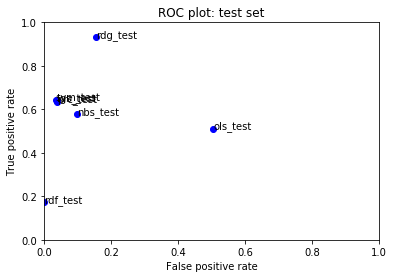

In [41]:
fits = [ols_performance_test, svm_performance_test, lgs_performance_test, nbs_performance_test, prc_performance_test, rdg_performance_test, rdf_performance_test]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

---

# <span style="color:red">SUBMISSION</span>

---

In [42]:
# read in test data for submission
# CHANGE FILE PATH and my_random_seed number (any integer other than 74 will do): 
raw_data, X_test_submission = process_raw_data(fn='data/toxiccomments_test.csv', my_random_seed=97, test=True)
print("Number of rows in the submission test set (should be 153,164): ")

toxic_data is: <class 'pandas.core.frame.DataFrame'>
toxic_data has 153164 rows and 2 columns 

the data types for each of the columns in toxic_data:
id              object
comment_text    object
dtype: object 

the first 10 rows in toxic_data:
                 id                                       comment_text
0  00001cee341fdb12  Yo bitch Ja Rule is more succesful then you'll...
1  0000247867823ef7  == From RfC == \n\n The title is fine as it is...
2  00013b17ad220c46  " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3  00017563c3f7919a  :If you have a look back at the source, the in...
4  00017695ad8997eb          I don't anonymously edit articles at all.
Shape of HashingVectorizer X:
(153164, 10000)
Look at a few rows of the new quantitative features: 
    exclam_count  uppercase  questions
0              0          0          0
1              0          0          0
2              0          0          0
3              0          0          0
4              0          0       

---

Choose a <span style="color:red">*single*</span> model for your submission. In this code, I am choosing the Ordinary Least Squares model fit, which is in the `ols` object. But you should choose the model that is performing the best for you! 

In [43]:
# store the id from the raw data
my_submission = pd.DataFrame(raw_data["id"])
# concatenate predictions to the id
my_submission["prediction"] = rdg.predict(X_test_submission)
# look at the proportion of positive predictions
print(my_submission['prediction'].mean())

0.3576297302238124


In [44]:
raw_data.head()

,id,comment_text,exclam_count,uppercase,questions
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...,0,0,0
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...,0,0,0
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0,0,0
3,00017563c3f7919a,":If you have a look back at the source, the in...",0,0,0
4,00017695ad8997eb,I don't anonymously edit articles at all.,0,0,0


In [45]:
my_submission.head()

,id,prediction
0,00001cee341fdb12,True
1,0000247867823ef7,True
2,00013b17ad220c46,False
3,00017563c3f7919a,False
4,00017695ad8997eb,False


In [46]:
my_submission.shape

(153164, 2)

In [47]:
# export submission file as pdf
# CHANGE FILE PATH: 
my_submission.to_csv('data/toxiccomments_submission.csv', index=False)

# Submit to Canvas: 1) the CSV file that was written in the previous cell and 2) the url to the repository (GitHub or other) that contains your code and documentation